In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
movie_df = pd.read_csv(
    "data/ml-100k/u.item",
    sep="|",
    header=None,
    encoding="latin1",
    index_col=False,
    names=[
        "movie_id",
        "movie_title",
        "release_date",
        "video_release_date",
        "imdb_url",
        "unknown",
        "action",
        "adventure",
        "animation",
        "children",
        "comedy",
        "crime",
        "documentary",
        "drama",
        "fantasy",
        "film_noir",
        "horror",
        "musical",
        "mystery" "romance",
        "sci_fi",
        "thriller",
        "war",
        "western",
    ],
)
movie_df.movie_id -= 1  # make this column zero-indexed
movie_df.head()

/tmp/ipykernel_1057888/1570839442.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  movie_df = pd.read_csv(


,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,...,drama,fantasy,film_noir,horror,musical,mysteryromance,sci_fi,thriller,war,western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
rating_df = pd.read_csv(
    "data/ml-100k/u.data",
    sep="\t",
    header=None,
    names=["user_id", "movie_id", "rating", "timestamp"],
)
rating_df.user_id -= 1  # make this column zero-indexed
rating_df.movie_id -= 1  # make this column zero-indexed
rating_df.head()
reward_threshold = 4
movie_counts = (
    rating_df.groupby("movie_id")["rating"].count().sort_values(ascending=False)
)
print("Number of movies", rating_df["movie_id"].nunique())
n_movies = 800 #rating_df["movie_id"].nunique()
top_n_movies = rating_df.query(
    "movie_id in {}".format((movie_counts[:n_movies].index.values.tolist()))
)
top_n_movies = top_n_movies.merge(
    movie_df[["movie_id", "movie_title"]], on="movie_id", how="left"
).drop(columns=["timestamp"])
top_n_movies.movie_title = top_n_movies.movie_title.str.replace(
    "\s+\(.+\)", ""
).str.strip()
top_n_movies.head()

Number of movies 1682


,user_id,movie_id,rating,movie_title
0,195,241,3,Kolya (1996)
1,185,301,3,L.A. Confidential (1997)
2,243,50,2,Legends of the Fall (1994)
3,165,345,1,Jackie Brown (1997)
4,297,473,4,Dr. Strangelove or: How I Learned to Stop Worr...


In [ ]:
reward_threshold = 4
rating_df = top_n_movies
rating_df["reward"] = rating_df.eval("rating > @reward_threshold").astype(int)
rating_df.head()
rating_df.shape

(96056, 5)

## Bandits replayers

In [ ]:
from tqdm.auto import tqdm


class ReplaySimulator:
    def __init__(
        self,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
        random_seed=1,
    ):
        np.random.seed(random_seed)
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.n_visits = n_visits
        self.n_iterations = n_iterations
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        results = []
        for iteration in tqdm(range(self.n_iterations), total=self.n_iterations):
            self.reset()
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in tqdm(range(self.n_visits), desc="Visits", total=self.n_visits, leave=False):
                found_match = False
                while not found_match:
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    reward = self.reward_history.query(
                        f"{self.item_col_name} == @item_id and {self.visitor_col_name} == @visitor_id"
                    )[self.reward_col_name]
                    found_match = reward.shape[0] > 0

                reward_value = reward.iloc[0]
                self.record_result(visit, item_idx, reward_value)
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards / (visit + 1)

                results.append(
                    {
                        "iteration": iteration,
                        "visit": visit,
                        "item_id": item_id,
                        "visitor_id": visitor_id,
                        "reward": reward_value,
                        "total_reward": total_rewards,
                        "fraction_relevant": fraction_relevant[visit],
                    }
                )

        return results

    def select_item(self):
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        self.n_item_samples[item_idx] += 1
        alpha = 1.0 / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (
            reward - self.n_item_rewards[item_idx]
        )

### Policies

In [55]:
class RandomReplayer(ReplaySimulator):
    def __init__(
        self,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
    ):
        super(RandomReplayer, self).__init__(
            n_visits,
            reward_history,
            item_col_name,
            visitor_col_name,
            reward_col_name,
            n_iterations,
        )

    def select_item(self):
        return np.random.choice(len(self.n_item_rewards))

In [60]:
class EpsilonGreedyReplayer(ReplaySimulator):
    def __init__(
        self,
        epsilon,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
    ):
        super(EpsilonGreedyReplayer, self).__init__(
            n_visits,
            reward_history,
            item_col_name,
            visitor_col_name,
            reward_col_name,
            n_iterations,
        )
        self.epsilon = epsilon

    def select_item(self):
        if np.random.uniform() < self.epsilon:  # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
        else:
            item_id = np.argmax(self.n_item_rewards)
        return item_id

In [59]:
class ThompsonSamplingReplayer(ReplaySimulator):
    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
        samples = [np.random.beta(a, b) for a, b in zip(self.alphas, self.betas)]
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1

## Run

In [45]:
n_visits = 10000
n_iterations = 5

reward_history = rating_df
item_col_name = "movie_id"
visitor_col_name = "user_id"
reward_col_name = "reward"

epsilon = 0.05
epsilon_005_results = EpsilonGreedyReplayer(
    epsilon,
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()
epsilon_005_results_df = pd.DataFrame(epsilon_005_results)
epsilon_005_results_df.head()

epsilon = 0.1
epsilon_01_results = EpsilonGreedyReplayer(
    epsilon,
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

epsilon_01_results_df = pd.DataFrame(epsilon_01_results)
epsilon_01_results_df.head()
random_results = RandomReplayer(
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

random_df = pd.DataFrame(random_results)
random_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,241,591,1,1,1.000000
1,0,1,241,62,0,1,0.500000
2,0,2,241,640,1,2,0.666667
3,0,3,241,239,1,3,0.750000
4,0,4,241,138,0,3,0.600000


In [65]:
ts_replayer = ThompsonSamplingReplayer(
    n_visits,
    reward_history,
    item_col_name,
    visitor_col_name,
    reward_col_name,
    n_iterations=n_iterations,
).replay()

ts_df = pd.DataFrame(ts_replayer)
ts_df.head()

  0%|          | 0/10 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

Visits:   0%|          | 0/10000 [00:00<?, ?it/s]

,iteration,visit,item_id,visitor_id,reward,total_reward,fraction_relevant
0,0,0,99,282,0,0,0.0
1,0,1,789,494,0,0,0.0
2,0,2,730,755,0,0,0.0
3,0,3,362,144,0,0,0.0
4,0,4,918,175,0,0,0.0


In [62]:
epsilon_005_avg_results_df = epsilon_005_results_df.groupby(
    "visit", as_index=False
).mean()
epsilon_005_avg_results_df
epsilon_01_avg_results_df = epsilon_01_results_df.groupby(
    "visit", as_index=False
).mean()
epsilon_01_avg_results_df
random_avg_results = random_df.groupby("visit", as_index=False).mean()
ts_avg_results = ts_df.groupby("visit", as_index=False).mean()

<AxesSubplot:xlabel='visit', ylabel='fraction_relevant'>

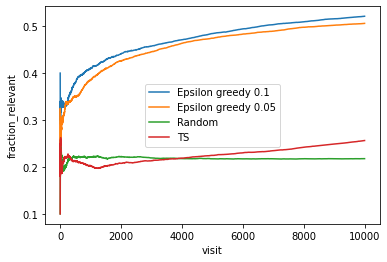

In [64]:
fig, ax = plt.subplots()
sns.lineplot(data=epsilon_01_avg_results_df, x="visit", y="fraction_relevant", label="Epsilon greedy 0.1", ax=ax)
sns.lineplot(
    data=epsilon_005_avg_results_df,
    x="visit",
    y="fraction_relevant",
    label="Epsilon greedy 0.05",
    ax=ax
)
sns.lineplot(
    data=random_avg_results,
    x="visit",
    y="fraction_relevant",
    label="Random",
    ax=ax,
)
sns.lineplot(
    data=ts_avg_results,
    x="visit",
    y="fraction_relevant",
    label="Thompson Sampling",
    ax=ax,
)
ax.set_ylabel("Proportion of relevant recommendation")
# ax.set_yscale("log")

## Adding the TwoThird rule

In [ ]:
class ReplaySimulatorCrowd:
    def __init__(
        self,
        n_visits,
        reward_history,
        item_col_name,
        visitor_col_name,
        reward_col_name,
        n_iterations=1,
        threshold=2/3,
        random_seed=1,
    ):
        np.random.seed(random_seed)
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.n_visits = n_visits
        self.threshold = threshold
        self.n_iterations = n_iterations
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros((self.n_items, 2))

    def replay(self):
        results = []
        for iteration in tqdm(range(self.n_iterations), total=self.n_iterations):
            self.reset()
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)
            items_threshold = np.zeros(self.n_items)
            item_allowed = np.ones(self.n_items)
            for visit in tqdm(range(self.n_visits), desc="Visits", total=self.n_visits, leave=False):
                found_match = False
                while not found_match:
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]
                    item_idx = self.select_item(item_allowed)
                    item_id = self.items[item_idx]
                    reward = self.reward_history.query(
                        f"{self.item_col_name} == @item_id and {self.visitor_col_name} == @visitor_id"
                    )[self.reward_col_name]
                    found_match = reward.shape[0] > 0

                reward_value = reward.iloc[0]
                items_threshold[item_idx, reward] += 1
                max_item = items_threshold[item_idx, :].max()
                if max_item >= 2 and max_item/items_threshold[item_idx, :].sum() >= self.threshold:
                    item_allowed[item_idx] = False
                self.record_result(visit, item_idx, reward_value)
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards / (visit + 1)

                results.append(
                    {
                        "iteration": iteration,
                        "visit": visit,
                        "item_id": item_id,
                        "visitor_id": visitor_id,
                        "reward": reward_value,
                        "total_reward": total_rewards,
                        "fraction_relevant": fraction_relevant[visit],
                    }
                )

        return results

    def select_item(self):
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        self.n_item_samples[item_idx] += 1
        alpha = 1.0 / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (
            reward - self.n_item_rewards[item_idx]
        )